In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from autotemplate.extract_utils import extract_from_rxn_smiles, canon_remap
from autotemplate.run_utils import rdchiralRunText_modified, RemoveReagent, clearIsotope
from autotemplate.graph_utils import mapping_for_gold_multiple_smiles, find_unique_templates_dict, countBCN, GetAnswer

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdChemReactions as Reactions
from rdkit.Chem.Draw import IPythonConsole
from PIL import Image


## 1. Overview of different types of reaction error

### (1) Molecules absent in reactant site.

original reaction type: ReductiveAmination, reaction id: 33800230


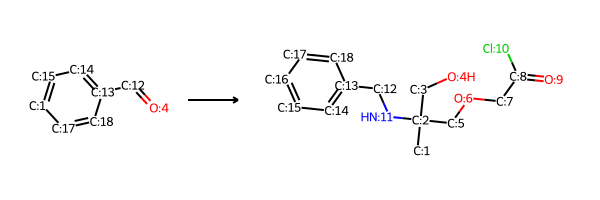

After processed:


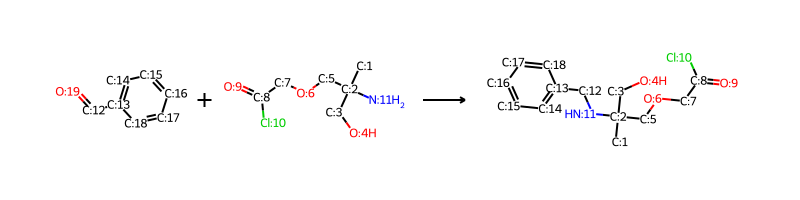

In [3]:
rxn_type = "ReductiveAmination"
rxn_id = 33800230
original_rxn = "[cH:1]1[cH:15][cH:14][c:13]([CH:12]=[O:4])[cH:18][cH:17]1>>[CH3:1][C:2]([CH2:3][OH:4])([CH2:5][O:6][CH2:7][C:8](=[O:9])[Cl:10])[NH:11][CH2:12][c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)
correct_rxn = "[CH:12]([c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1)=[O:19].[CH3:1][C:2]([CH2:3][OH:4])([CH2:5][O:6][CH2:7][C:8](=[O:9])[Cl:10])[NH2:11]>>[CH3:1][C:2]([CH2:3][OH:4])([CH2:5][O:6][CH2:7][C:8](=[O:9])[Cl:10])[NH:11][CH2:12][c:13]1[cH:14][cH:15][cH:16][cH:17][cH:18]1"
rxn_2 = Reactions.ReactionFromSmarts(correct_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("After processed:")
display(Draw.ReactionToImage(rxn_2))

### (2) Somehow new atoms in the product site

original reaction type: DielsAlder, reaction id: 30743792


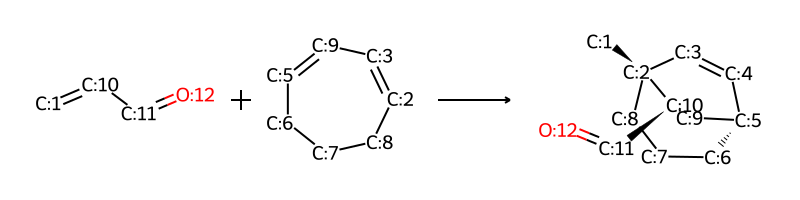

--- This reaction should be discarded because of the unmatched C:1 atom in the product site. ---


In [4]:
rxn_type = "DielsAlder"
rxn_id = 30743792
original_rxn = "[CH2:1]=[CH:10][CH:11]=[O:12].[CH:2]1=[CH:3][CH:9]=[CH:5][CH2:6][CH2:7][CH2:8]1>>[CH3:1][C@:2]12[CH:3]=[CH:4][C@H:5]([CH2:6][CH2:7][CH2:8]1)[CH2:9][C@H:10]2[CH:11]=[O:12]"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of the unmatched C:1 atom in the product site. ---")

original reaction type: Friedel-CraftsAcylation, reaction id: 40781365


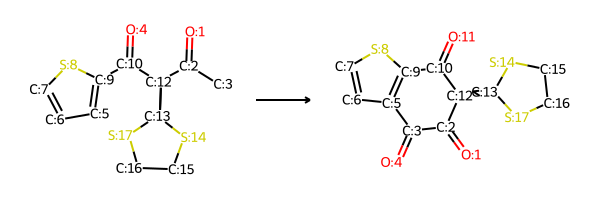

--- This reaction should be discarded because of the unmatched O:4 atom in the product site. ---


In [5]:
rxn_type = "Friedel-CraftsAcylation"
rxn_id = 40781365
original_rxn = "[O:1]=[C:2]([CH3:3])[C:12]([C:10](=[O:4])[c:9]1[cH:5][cH:6][cH:7][s:8]1)=[C:13]1[S:14][CH2:15][CH2:16][S:17]1>>[O:1]=[C:2]1[C:3](=[O:4])[c:5]2[cH:6][cH:7][s:8][c:9]2[C:10](=[O:11])[C:12]1=[C:13]1[S:14][CH2:15][CH2:16][S:17]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of the unmatched O:4 atom in the product site. ---")

### (3) The uncommon reaction not belonging to its reaction type (with too less templates)

original reaction type: DielsAlder, reaction id: 9021436


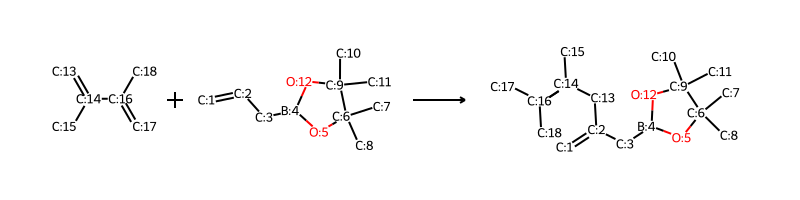

--- This reaction should be discarded because of its too rare reaction template. ---


In [6]:
rxn_type = "DielsAlder"
rxn_id = 9021436
original_rxn = "[CH2:13]=[C:14]([CH3:15])[C:16](=[CH2:17])[CH3:18].[CH2:1]=[CH:2][CH2:3][B:4]1[O:5][C:6]([CH3:7])([CH3:8])[C:9]([CH3:10])([CH3:11])[O:12]1>>[CH2:1]=[C:2]([CH2:3][B:4]1[O:5][C:6]([CH3:7])([CH3:8])[C:9]([CH3:10])([CH3:11])[O:12]1)[CH2:13][C:14]([CH3:15])=[C:16]([CH3:17])[CH3:18]"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of its too rare reaction template. ---")

### (4) Wrong reaction records (cannot be recovered by any other reaction template in the records)

original reaction type: PausonKhandReaction, reaction id: 44882622


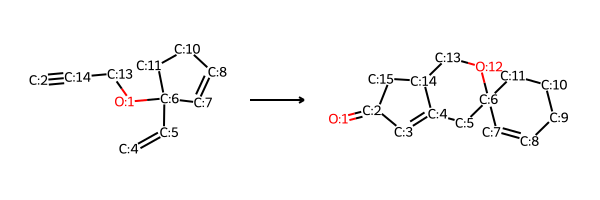

--- This reaction should be discarded because of the wrong manual recording. ---
In the reference, https://www.tandfonline.com/doi/full/10.1080/00397911.2016.1274032
The expected reactant of this reaction should be:
[CH:3]#[C:4][CH2:5][C:6]1([O:12][CH2:13][CH:14]=[CH2:15])[CH:7]=[CH:8][CH2:9][CH2:10][CH2:11]1.[O:1]=[C:2]>>[O:1]=[C:2]1[CH:3]=[C:4]2[CH2:5][C:6]3([CH:7]=[CH:8][CH2:9][CH2:10][CH2:11]3)[O:12][CH2:13][CH:14]2[CH2:15]1
2-3-1.0;14-15-1.0;3-4-2.0;4-14-1.0;2-15-1.0


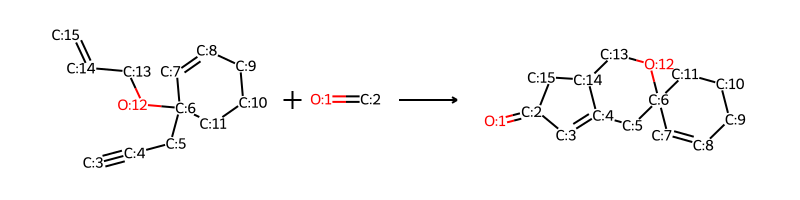

In [16]:
rxn_type = "PausonKhandReaction"
rxn_id = 44882622
original_rxn = "[O:1]([C:6]1([CH:5]=[CH2:4])[CH:7]=[CH:8][CH2:10][CH2:11]1)[CH2:13][C:14]#[CH:2]>>[O:1]=[C:2]1[CH:3]=[C:4]2[CH2:5][C:6]3([CH:7]=[CH:8][CH2:9][CH2:10][CH2:11]3)[O:12][CH2:13][CH:14]2[CH2:15]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))
print("--- This reaction should be discarded because of the wrong manual recording. ---")

print("In the reference, https://www.tandfonline.com/doi/full/10.1080/00397911.2016.1274032")
print("The expected reactant of this reaction should be:")

template = "[#6:4]1-[#6:5]-[#6:1]-[#6:2]=[#6:3]-1>>[#6;H0:1].[#6:2]#[#6:3].[#6:4]=[#6:5]"
product = original_rxn.split('>>')[1]
correct_rxn = rdchiralRunText_modified(template, product)[0] + '>>' + product
print(correct_rxn)
print(GetAnswer(correct_rxn))
rxn_2 = Reactions.ReactionFromSmarts(correct_rxn, useSmiles=True)
display(Draw.ReactionToImage(rxn_2))

# 2. Template extraction procedure and illustration
#### It should be noted that the atom charge and radical site cannot be visualized using RDkit package.

### (1) An simple normal case illustration

original reaction type: GrignardReaction, reaction id: 10279043


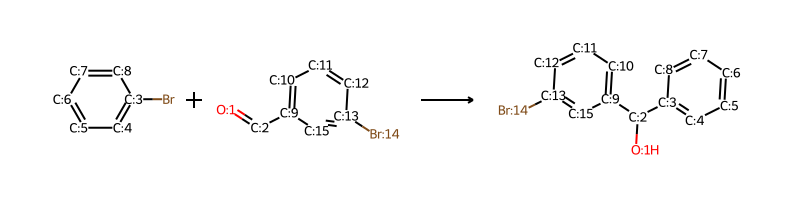

The extracted template is:
[#6:1]-[#6:2]-[#8:3]>>Br-[#6:1].[#6:2]=[#8:3]


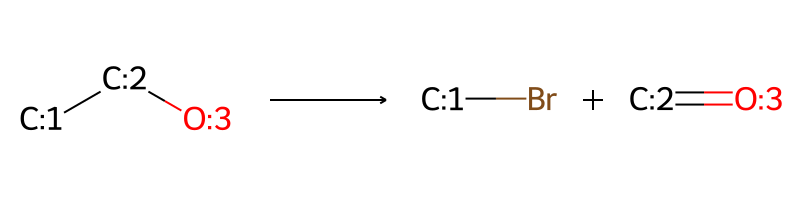

In [8]:
rxn_type = "GrignardReaction"
rxn_id = 10279043
original_rxn = "Br[c:3]1[cH:4][cH:5][cH:6][cH:7][cH:8]1.[O:1]=[CH:2][c:9]1[cH:10][cH:11][cH:12][c:13]([Br:14])[cH:15]1>>[OH:1][CH:2]([c:3]1[cH:4][cH:5][cH:6][cH:7][cH:8]1)[c:9]1[cH:10][cH:11][cH:12][c:13]([Br:14])[cH:15]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))

print("The extracted template is:")
template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

### (2) Include the charge if the charge of atom is changed

original reaction type: FischerIndoleSynthesis, reaction id: 24876608
7-8-1.0;6-22-1.0;9-22-1.0;8-9-1.0


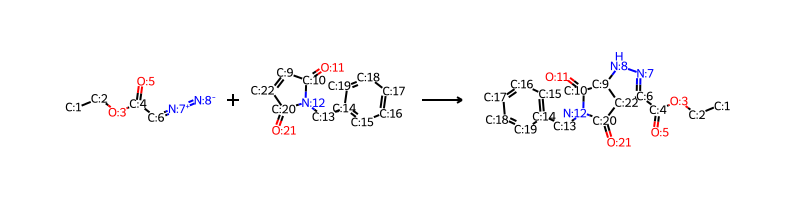

[#6:1]1-[#6:3]=[#7:4]-[#7:5]-[#6:2]-1>>[#6:1]=[#6:2].[#6:3]=[#7;+1:4]=[#7;-1:5]


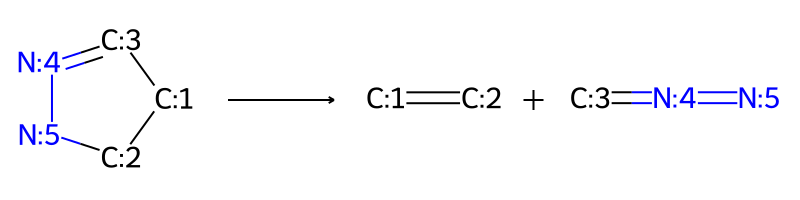

In [17]:
rxn_type = "FischerIndoleSynthesis"
rxn_id = 24876608
original_rxn = "[CH3:1][CH2:2][O:3][C:4](=[O:5])[CH:6]=[N+:7]=[N-:8].[CH:9]1=[CH:22][C:20](=[O:21])[N:12]([CH2:13][c:14]2[cH:15][cH:16][cH:17][cH:18][cH:19]2)[C:10]1=[O:11]>>[CH3:1][CH2:2][O:3][C:4](=[O:5])[C:6]1=[N:7][NH:8][CH:9]2[C:10](=[O:11])[N:12]([CH2:13][c:14]3[cH:15][cH:16][cH:17][cH:18][cH:19]3)[C:20](=[O:21])[CH:22]12 "
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
print(GetAnswer(original_rxn))
display(Draw.ReactionToImage(rxn_1))

template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

### (3)	Include the number of hydrogen if the atom is radical

original reaction type: PausonKhandReaction, reaction id: 45385271
16-17-1.0;11-16-1.0;12-13-1.0;13-15-1.0;11-12-2.0


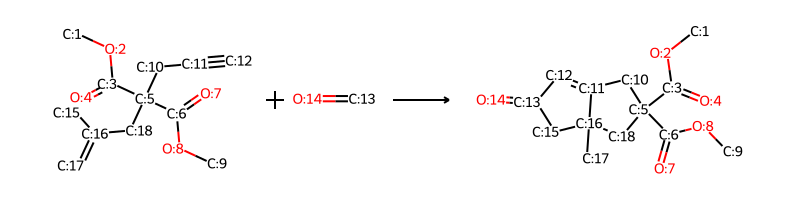

[#6:6]-[#6:5]1-[#6:2]=[#6:3]-[#6:1]-[#6:4]-1>>[#6;H0:1].[#6:2]#[#6:3].[#6:4]-[#6:5]=[#6:6]


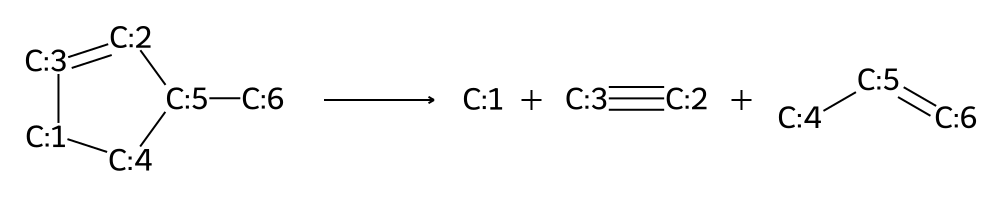

In [20]:
rxn_type = "PausonKhandReaction"
rxn_id = 4990712
original_rxn = "[CH3:1][O:2][C:3](=[O:4])[C:5]([C:6](=[O:7])[O:8][CH3:9])([CH2:10][C:11]#[CH:12])[CH2:18][C:16]([CH3:15])=[CH2:17].[C:13]=[O:14]>>[CH3:1][O:2][C:3](=[O:4])[C:5]1([C:6](=[O:7])[O:8][CH3:9])[CH2:10][C:11]2=[CH:12][C:13](=[O:14])[CH2:15][C:16]2([CH3:17])[CH2:18]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
print(GetAnswer(original_rxn))
display(Draw.ReactionToImage(rxn_1))

template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

### (4)	Include the path atoms between the separate reaction center

original reaction type: FischerIndoleSynthesis, reaction id: 35784196


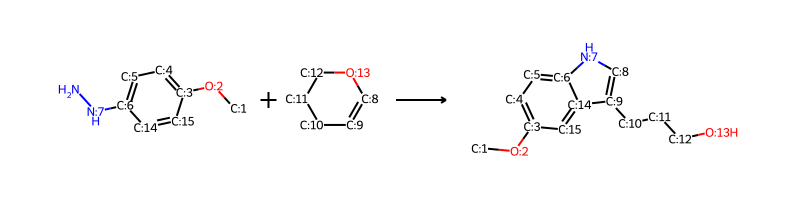

[#8:7]-[#6:6]-[#6:5]-[#6:4]-[#6:9]1:[#6:3]:[#6:2]:[#7:1]:[#6:8]:1>>N-[#7:1]-[#6:2]:[#6:3].[#6:4]1-[#6:5]-[#6:6]-[#8:7]-[#6:8]=[#6:9]-1


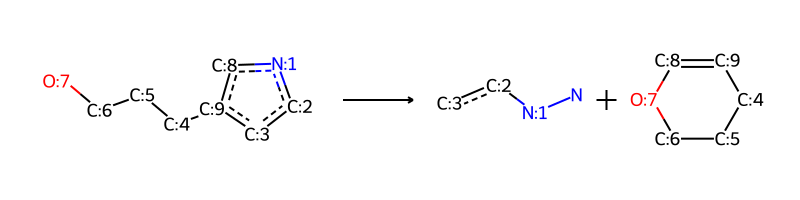

In [11]:
rxn_type = "FischerIndoleSynthesis"
rxn_id = 35784196
original_rxn = "N[NH:7][c:6]1[cH:5][cH:4][c:3]([O:2][CH3:1])[cH:15][cH:14]1.[CH:8]1=[CH:9][CH2:10][CH2:11][CH2:12][O:13]1>>[CH3:1][O:2][c:3]1[cH:4][cH:5][c:6]2[nH:7][cH:8][c:9]([CH2:10][CH2:11][CH2:12][OH:13])[c:14]2[cH:15]1"
rxn_1 = Reactions.ReactionFromSmarts(original_rxn, useSmiles=True)

print("original reaction type: {}, reaction id: {}".format(rxn_type, rxn_id))
display(Draw.ReactionToImage(rxn_1))

template = extract_from_rxn_smiles(original_rxn)
rxn_smarts = Reactions.ReactionFromSmarts(template, useSmiles=False)
print(template)
display(Draw.ReactionToImage(rxn_smarts))

# 3. Template canonicalization (to reduce the redudant templates)
### (1) Merge the same reaction template (use graph isomorphism to check the reactant and porduct pairs)

In [12]:
pass

### (2) Merge the reaction template with more "bond change number" into the reaction template with less "bond change number".

The first template has BCN = 7
[#16:1]1-[#6:3]-[#6:4]=[#6:6]-[#6:5]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]
answer: 1-3-0.0;3-4-2.0;4-5-1.0;1-2-2.0;5-6-2.0;4-6-0.0;2-5-0.0


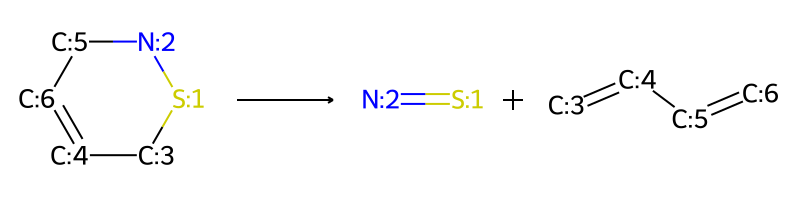

The second template has BCN = 6
[#16:1]1-[#6:6]-[#6:5]=[#6:4]-[#6:3]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]
answer: 1-6-0.0;3-4-2.0;4-5-1.0;1-2-2.0;2-3-0.0;5-6-2.0


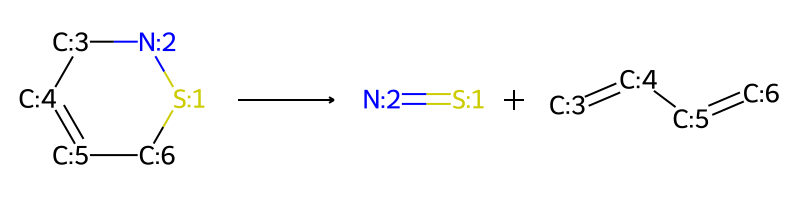

In [13]:
template_1 = "[#16:1]1-[#6:3]-[#6:4]=[#6:6]-[#6:5]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]"
template_2 = "[#16:1]1-[#6:6]-[#6:5]=[#6:4]-[#6:3]-[#7:2]-1>>[#16:1]=[#7:2].[#6:3]=[#6:4]-[#6:5]=[#6:6]"
rxn_smarts_1 = Reactions.ReactionFromSmarts(template_1, useSmiles=False)
rxn_smarts_2 = Reactions.ReactionFromSmarts(template_2, useSmiles=False)

print("The first template has BCN = {}".format(countBCN(template_1)))
print(template_1)
print("answer:", GetAnswer(template_1))
display(Draw.ReactionToImage(rxn_smarts_1))

print("The second template has BCN = {}".format(countBCN(template_2)))
print(template_2)
print("answer:", GetAnswer(template_2))
display(Draw.ReactionToImage(rxn_smarts_2))